In [3]:
pip install pandas faker

In [4]:
import pandas as pd
import random
from faker import Faker
from datetime import datetime
import calendar
import os

# -----------------------------
# Setup
# -----------------------------

# Initialize Faker and random seed
fake = Faker()
random.seed(42)
Faker.seed(42)

# Output directory for CSV files
output_dir = "monthly_expense_data"
os.makedirs(output_dir, exist_ok=True)

# -----------------------------
# Define Expense Categories and Payment Modes
# -----------------------------

categories = {
    "Food": (100, 500),
    "Travel": (500, 5000),
    "Bills": (200, 1500),
    "Groceries": (300, 2000),
    "Subscriptions": (100, 1000),
    "Entertainment": (200, 2000),
    "Gifts": (100, 1500),
    "Shopping": (500, 5000),
    "Healthcare": (300, 2500),
    "Education": (1000, 8000)
}

payment_modes = ["Cash", "UPI", "Credit Card", "Debit Card", "Netbanking"]

# -----------------------------
# Generate Expense Data for Each Month
# -----------------------------

year = 2025

for month in range(1, 13):  # Loop from January to December
    month_data = []
    _, days_in_month = calendar.monthrange(year, month)

    num_transactions = random.randint(80, 120)  # Number of transactions per month

    for _ in range(num_transactions):
        category = random.choice(list(categories.keys()))
        min_amt, max_amt = categories[category]
        amount = round(random.uniform(min_amt, max_amt), 2)

        # 30% chance to receive cashback
        cashback = round(random.uniform(0, amount * 0.1), 2) if random.random() < 0.3 else 0.0

        transaction = {
            "Date": fake.date_between(start_date=datetime(year, month, 1), 
                                      end_date=datetime(year, month, days_in_month)),
            "Category": category,
            "Payment_Mode": random.choice(payment_modes),
            "Description": fake.sentence(nb_words=4),
            "Amount_Paid": amount,
            "Cashback": cashback
        }

        month_data.append(transaction)

    # Convert to DataFrame
    df = pd.DataFrame(month_data)

    # Save CSV
    month_name = calendar.month_name[month]
    filename = f"{output_dir}/{month_name}_2025.csv"
    df.to_csv(filename, index=False)

    print(f"[✓] {month_name} 2025 - {len(df)} records saved to {filename}")


[✓] January 2025 - 120 records saved to monthly_expense_data/January_2025.csv
[✓] February 2025 - 119 records saved to monthly_expense_data/February_2025.csv
[✓] March 2025 - 109 records saved to monthly_expense_data/March_2025.csv
[✓] April 2025 - 101 records saved to monthly_expense_data/April_2025.csv
[✓] May 2025 - 82 records saved to monthly_expense_data/May_2025.csv
[✓] June 2025 - 95 records saved to monthly_expense_data/June_2025.csv
[✓] July 2025 - 84 records saved to monthly_expense_data/July_2025.csv
[✓] August 2025 - 112 records saved to monthly_expense_data/August_2025.csv
[✓] September 2025 - 100 records saved to monthly_expense_data/September_2025.csv
[✓] October 2025 - 103 records saved to monthly_expense_data/October_2025.csv
[✓] November 2025 - 110 records saved to monthly_expense_data/November_2025.csv
[✓] December 2025 - 104 records saved to monthly_expense_data/December_2025.csv


In [13]:
pip install pandas sqlalchemy


Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import os
from sqlalchemy import create_engine

# -----------------------------
# Configuration
# -----------------------------
csv_folder = "monthly_expense_data"
db_name = "personal_expenses.db"
table_name = "expenses"

# -----------------------------
# Connect to SQLite
# -----------------------------
engine = create_engine(f"sqlite:///{db_name}")

# -----------------------------
# Read all CSV files and combine
# -----------------------------
all_dataframes = []

for file in os.listdir(csv_folder):
    if file.endswith(".csv"):
        filepath = os.path.join(csv_folder, file)
        df = pd.read_csv(filepath)

        # Optional: Add Month column for easier analysis
        df['Month'] = file.replace(".csv", "")
        
        all_dataframes.append(df)

# Combine all months into one DataFrame
combined_df = pd.concat(all_dataframes, ignore_index=True)

# -----------------------------
# Clean up Column Formats
# -----------------------------
combined_df["Date"] = pd.to_datetime(combined_df["Date"])
combined_df["Amount_Paid"] = combined_df["Amount_Paid"].astype(float)
combined_df["Cashback"] = combined_df["Cashback"].astype(float)

# -----------------------------
# Load into SQLite
# -----------------------------
combined_df.to_sql(table_name, engine, if_exists='replace', index=False)

print(f"[✓] Loaded {len(combined_df)} records into '{table_name}' table in '{db_name}' database.")


[✓] Loaded 1239 records into 'expenses' table in 'personal_expenses.db' database.


In [1]:
import pandas as pd
import os
import sqlite3

# -----------------------------
# Configuration
# -----------------------------
csv_folder = "monthly_expense_data"         # Folder with 12 CSV files
db_file = "personal_expenses.db"            # SQLite DB file name
table_name = "expenses"

# -----------------------------
# Create SQLite DB connection
# -----------------------------
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

# -----------------------------
# Drop the table if it exists
# -----------------------------
cursor.execute(f"DROP TABLE IF EXISTS {table_name}")

# -----------------------------
# Create table schema
# -----------------------------
create_table_query = f"""
CREATE TABLE {table_name} (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date DATE,
    category TEXT,
    payment_mode TEXT,
    description TEXT,
    amount_paid REAL,
    cashback REAL,
    month TEXT
)
"""
cursor.execute(create_table_query)
print(f"[✓] Table '{table_name}' created in {db_file}.")

# -----------------------------
# Read & Insert CSVs
# -----------------------------
total_records = 0

for filename in os.listdir(csv_folder):
    if filename.endswith(".csv"):
        filepath = os.path.join(csv_folder, filename)
        df = pd.read_csv(filepath)

        # Add month column
        df['month'] = filename.replace(".csv", "")

        # Convert columns
        df['date'] = pd.to_datetime(df['Date']).dt.date
        df['amount_paid'] = df['Amount_Paid'].astype(float)
        df['cashback'] = df['Cashback'].astype(float)

        # Select and rename columns to match SQL
        df_sql = df[['date', 'Category', 'Payment_Mode', 'Description', 'amount_paid', 'cashback', 'month']]
        df_sql.columns = ['date', 'category', 'payment_mode', 'description', 'amount_paid', 'cashback', 'month']

        # Insert into SQLite
        df_sql.to_sql(table_name, conn, if_exists='append', index=False)
        print(f"[✓] Loaded: {filename} - {len(df_sql)} records")
        total_records += len(df_sql)

# -----------------------------
# Done
# -----------------------------
conn.commit()
conn.close()

print(f"\n[✔] All CSVs loaded successfully! Total records inserted: {total_records}")


[✓] Table 'expenses' created in personal_expenses.db.
[✓] Loaded: April_2025.csv - 101 records
[✓] Loaded: August_2025.csv - 112 records
[✓] Loaded: December_2025.csv - 104 records
[✓] Loaded: February_2025.csv - 119 records
[✓] Loaded: January_2025.csv - 120 records
[✓] Loaded: July_2025.csv - 84 records
[✓] Loaded: June_2025.csv - 95 records
[✓] Loaded: March_2025.csv - 109 records
[✓] Loaded: May_2025.csv - 82 records
[✓] Loaded: November_2025.csv - 110 records
[✓] Loaded: October_2025.csv - 103 records
[✓] Loaded: September_2025.csv - 100 records

[✔] All CSVs loaded successfully! Total records inserted: 1239


In [3]:
from sqlalchemy import create_engine
import pandas as pd

# Connect to SQLite database
engine = create_engine('sqlite:///personal_expenses.db')

# Helper function to run query and return DataFrame
def run_query(query):
    return pd.read_sql(query, engine)

In [7]:
pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24452\3610090144.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_spent', y='category', data=df, palette='viridis')


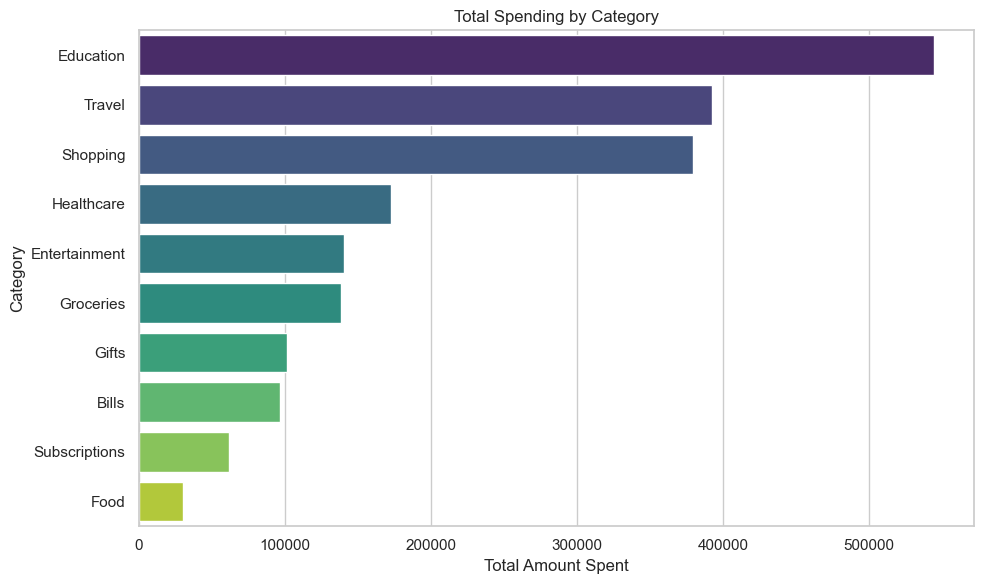

In [82]:
#Spending by Category
import matplotlib.pyplot as plt
import seaborn as sns

df = run_query("""
SELECT category, SUM(amount_paid) AS total_spent
FROM expenses
GROUP BY category
ORDER BY total_spent DESC
""")

plt.figure(figsize=(10,6))
sns.barplot(x='total_spent', y='category', data=df, palette='viridis')
plt.title("Total Spending by Category")
plt.xlabel("Total Amount Spent")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


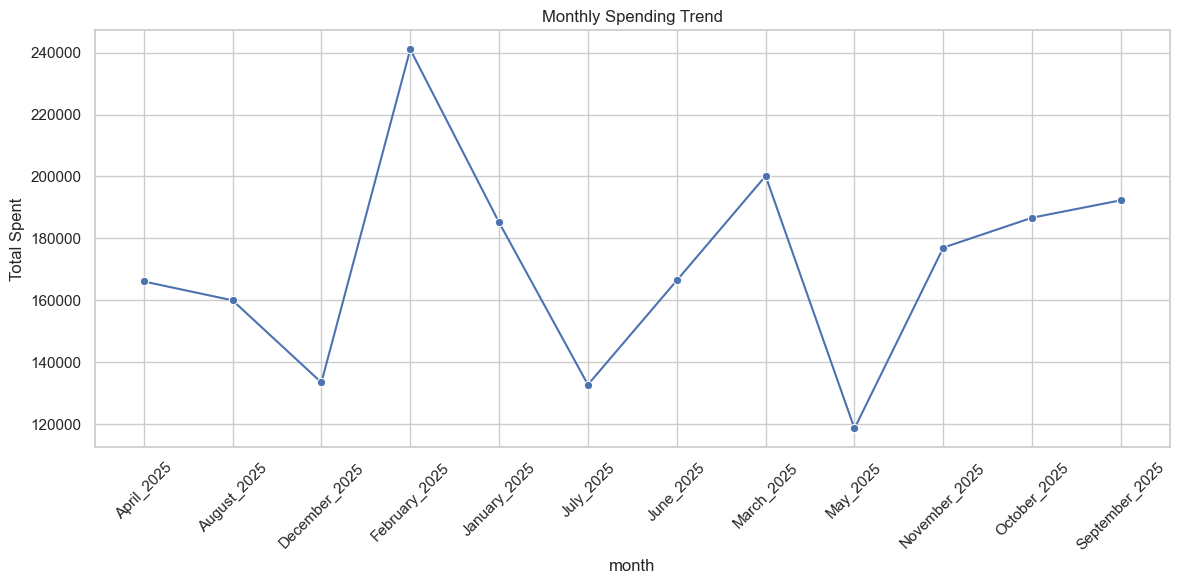

In [84]:
#Monthly Spending Trend
df = run_query("""
SELECT month, SUM(amount_paid) AS total_spent
FROM expenses
GROUP BY month
ORDER BY month
""")

plt.figure(figsize=(12,6))
sns.lineplot(x='month', y='total_spent', data=df, marker='o')
plt.title("Monthly Spending Trend")
plt.xticks(rotation=45)
plt.ylabel("Total Spent")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24452\683161164.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='total_cashback', data=df, palette='coolwarm')


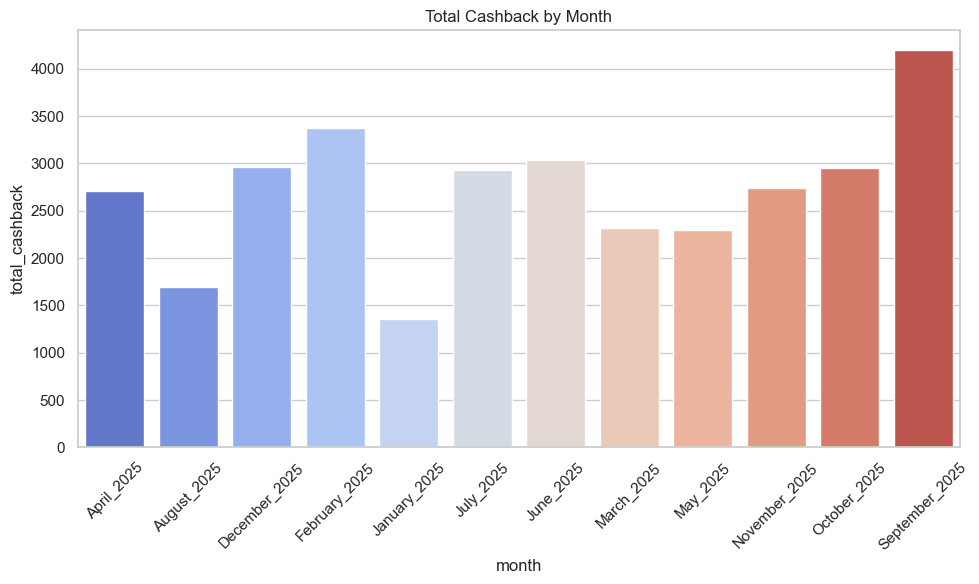

In [86]:
#Cashback by Month
df = run_query("""
SELECT month, SUM(cashback) AS total_cashback
FROM expenses
GROUP BY month
ORDER BY month
""")

plt.figure(figsize=(10,6))
sns.barplot(x='month', y='total_cashback', data=df, palette='coolwarm')
plt.title("Total Cashback by Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [88]:
pip install pandas sqlalchemy matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


[✓] Table created.
[+] Loaded April_2025.csv: 101 rows
[+] Loaded August_2025.csv: 112 rows
[+] Loaded December_2025.csv: 104 rows
[+] Loaded February_2025.csv: 119 rows
[+] Loaded January_2025.csv: 120 rows
[+] Loaded July_2025.csv: 84 rows
[+] Loaded June_2025.csv: 95 rows
[+] Loaded March_2025.csv: 109 rows
[+] Loaded May_2025.csv: 82 rows
[+] Loaded November_2025.csv: 110 rows
[+] Loaded October_2025.csv: 103 rows
[+] Loaded September_2025.csv: 100 rows
[✓] Done loading 1239 records.

[✓] Running key SQL queries...

[1] Total Spending by Category:
         category  total_spent
0      Education    544790.26
1         Travel    392831.18
2       Shopping    379291.26
3     Healthcare    173146.00
4  Entertainment    140390.04
5      Groceries    138733.23
6          Gifts    101734.74
7          Bills     96753.97
8  Subscriptions     62086.45
9           Food     30265.71

[3] Total Cashback Received:  32554.39


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24452\2737713566.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df1, x='total_spent', y='category', palette='Blues_d')


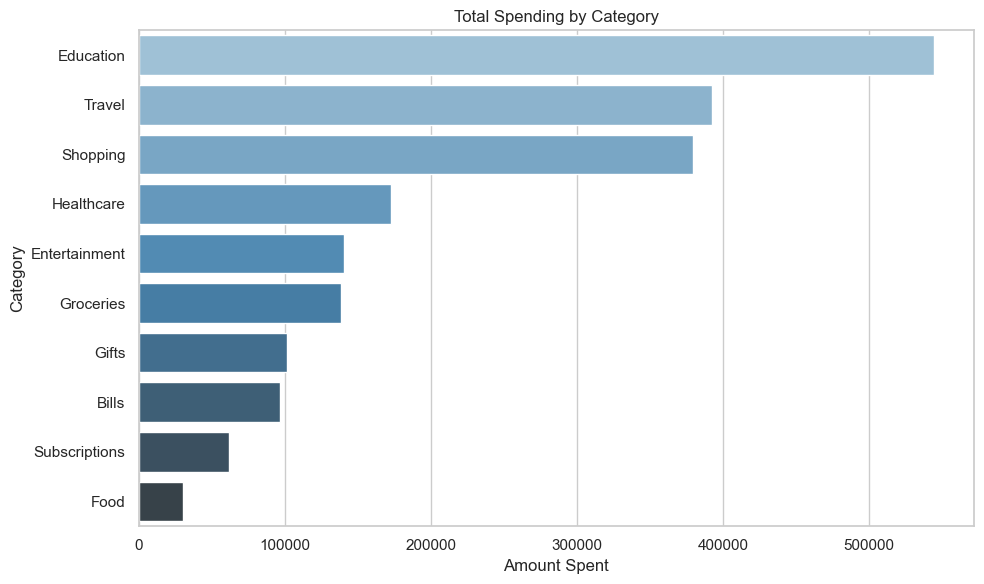

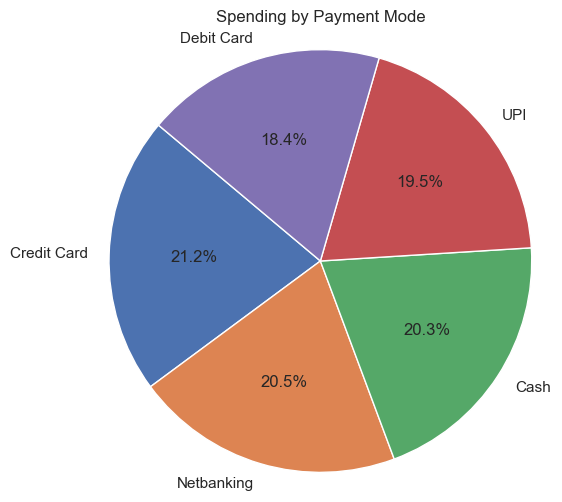

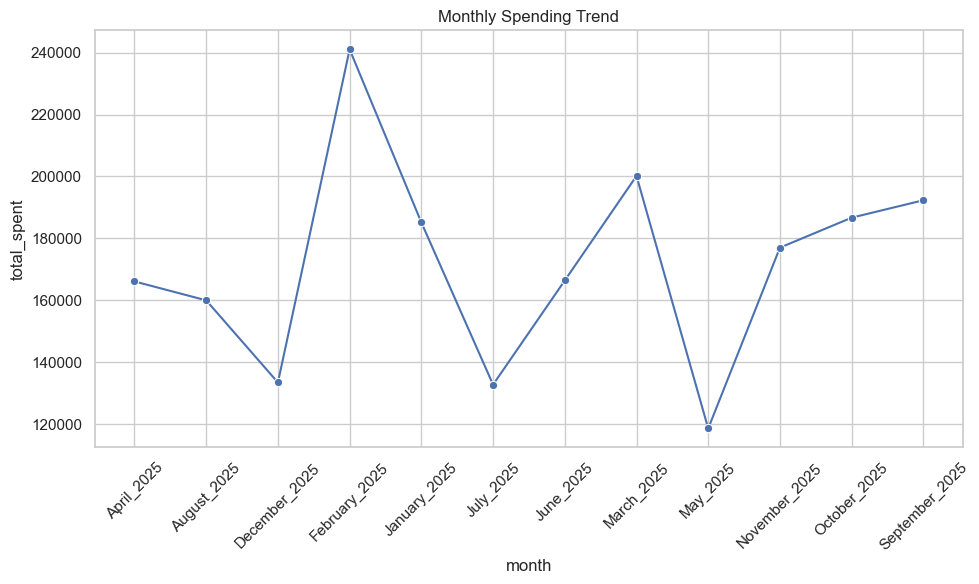

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24452\2737713566.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df6, x='weekday_name', y='avg_spend', palette='YlGnBu')


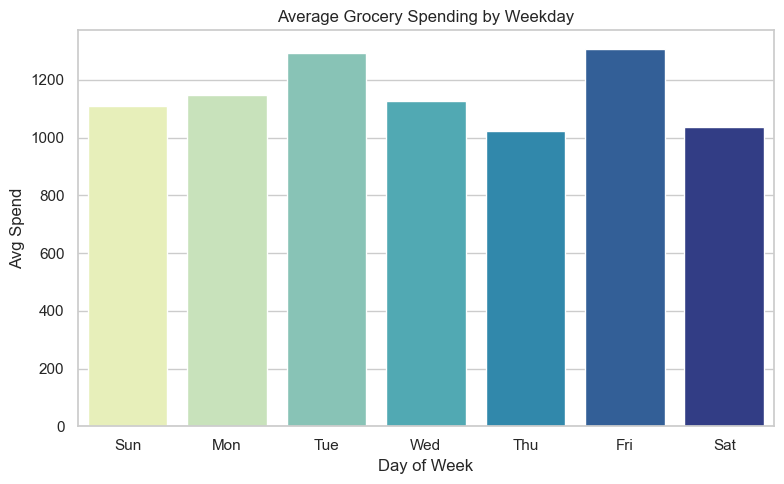


[✓] All queries and visualizations completed.


In [18]:
# expense_analysis.py

import pandas as pd
import os
import sqlite3
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Step 1: Load CSVs into SQLite
# -------------------------------

# Config
csv_folder = "monthly_expense_data"
db_file = "personal_expenses.db"
table_name = "expenses"

# Create SQLite DB and connect
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

# Drop existing table if exists
cursor.execute(f"DROP TABLE IF EXISTS {table_name}")

# Create new table
create_query = f"""
CREATE TABLE {table_name} (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date DATE,
    category TEXT,
    payment_mode TEXT,
    description TEXT,
    amount_paid REAL,
    cashback REAL,
    month TEXT
)
"""
cursor.execute(create_query)
print("[✓] Table created.")

# Load each CSV and insert into table
total_rows = 0
for file in os.listdir(csv_folder):
    if file.endswith(".csv"):
        path = os.path.join(csv_folder, file)
        df = pd.read_csv(path)
        df['month'] = file.replace(".csv", "")
        df['date'] = pd.to_datetime(df['Date']).dt.date
        df['amount_paid'] = df['Amount_Paid'].astype(float)
        df['cashback'] = df['Cashback'].astype(float)
        df_sql = df[['date', 'Category', 'Payment_Mode', 'Description', 'amount_paid', 'cashback', 'month']]
        df_sql.columns = ['date', 'category', 'payment_mode', 'description', 'amount_paid', 'cashback', 'month']
        df_sql.to_sql(table_name, conn, if_exists='append', index=False)
        print(f"[+] Loaded {file}: {len(df_sql)} rows")
        total_rows += len(df_sql)

conn.commit()
conn.close()
print(f"[✓] Done loading {total_rows} records.\n")

# -------------------------------
# Step 2: Connect to DB for Queries
# -------------------------------

engine = create_engine(f"sqlite:///{db_file}")

def run_query(query):
    return pd.read_sql(query, engine)

# -------------------------------
# Step 3: Run Example SQL Queries
# -------------------------------

print("[✓] Running key SQL queries...")

# 1. Total spending by category
q1 = """
SELECT category, SUM(amount_paid) AS total_spent
FROM expenses
GROUP BY category
ORDER BY total_spent DESC
"""
df1 = run_query(q1)
print("\n[1] Total Spending by Category:\n", df1)

# 2. Spending by Payment Mode
q2 = """
SELECT payment_mode, SUM(amount_paid) AS total_spent
FROM expenses
GROUP BY payment_mode
ORDER BY total_spent DESC
"""
df2 = run_query(q2)

# 3. Total cashback
q3 = "SELECT SUM(cashback) AS total_cashback FROM expenses"
df3 = run_query(q3)
print("\n[3] Total Cashback Received: ", df3.iloc[0, 0])

# 4. Top 5 Categories
df4 = run_query(q1 + " LIMIT 5")

# 5. Monthly Spending Trend
q5 = """
SELECT month, SUM(amount_paid) AS total_spent
FROM expenses
GROUP BY month
ORDER BY month
"""
df5 = run_query(q5)

# 6. Grocery Spending by Weekday
q6 = """
SELECT strftime('%w', date) AS weekday, AVG(amount_paid) AS avg_spend
FROM expenses
WHERE category = 'Groceries'
GROUP BY weekday
"""
df6 = run_query(q6)

# -------------------------------
# Step 4: Visualizations
# -------------------------------

sns.set(style="whitegrid")

# Barplot: Spending by Category
plt.figure(figsize=(10,6))
sns.barplot(data=df1, x='total_spent', y='category', palette='Blues_d')
plt.title("Total Spending by Category")
plt.xlabel("Amount Spent")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

# Pie Chart: Payment Mode Distribution
plt.figure(figsize=(6,6))
plt.pie(df2['total_spent'], labels=df2['payment_mode'], autopct='%1.1f%%', startangle=140)
plt.title("Spending by Payment Mode")
plt.axis('equal')
plt.show()

# Line Chart: Monthly Spending
plt.figure(figsize=(10,6))
sns.lineplot(data=df5, x='month', y='total_spent', marker='o')
plt.title("Monthly Spending Trend")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Barplot: Grocery Spending by Weekday
plt.figure(figsize=(8,5))
days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
df6['weekday'] = df6['weekday'].astype(int)
df6['weekday_name'] = df6['weekday'].apply(lambda x: days[x])
sns.barplot(data=df6, x='weekday_name', y='avg_spend', palette='YlGnBu')
plt.title("Average Grocery Spending by Weekday")
plt.xlabel("Day of Week")
plt.ylabel("Avg Spend")
plt.tight_layout()
plt.show()

print("\n[✓] All queries and visualizations completed.")
